# O algoritmo ICP

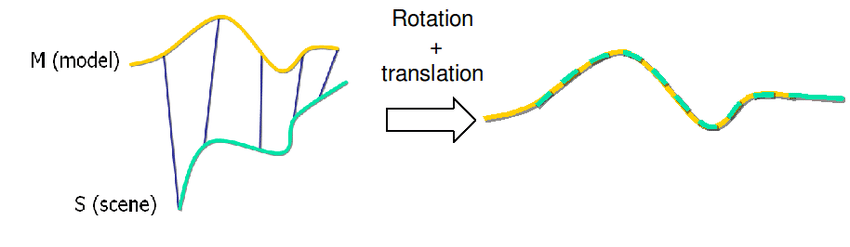

O algoritmo ICP (Iterative Closest Point) é uma técnica fundamental em processamento de nuvens de pontos e visão computacional. Ele é usado para registrar ou alinhar duas nuvens de pontos tridimensionais para determinar a transformação (rotação e translação) que melhor alinha uma nuvem de pontos à outra. O objetivo é encontrar a correspondência entre pontos nas duas nuvens e estimar a transformação que minimiza a distância entre os pontos correspondentes.

O ICP é amplamente utilizado em áreas como registro de imagens médicas, mapeamento 3D, navegação de robôs e realidade aumentada. Ele é eficaz para registrar nuvens de pontos quando uma estimativa aproximada da pose inicial está disponível e quando há sobreposição significativa entre as nuvens de pontos. No entanto, pode ser sensível a outliers e a escolha da estimativa de pose inicial é crucial para sua eficácia.

# O projeto

O estudo em questão tem por objetivo a aplicação do algoritmo ICP para a obtenção da trajetória de um veículo em três dimensões a partir das matrizes de transformação das 30 point clouds.

In [ ]:
!pip install tensorflow-graphics
!pip install trimesh

In [ ]:
import numpy as np
import trimesh
import os
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
!unzip 'KITTI-Sequence.zip'

In [ ]:
points = []
for f in os.listdir():
  for filename in os.listdir(f):
    if filename.endswith('obj'):
      index = filename[4:6]
      points.append('/content/0000'+str(index)+'/'+filename)

In [ ]:
points.sort()

In [ ]:
points

['/content/000000/000000_points.obj',
 '/content/000001/000001_points.obj',
 '/content/000002/000002_points.obj',
 '/content/000003/000003_points.obj',
 '/content/000004/000004_points.obj',
 '/content/000005/000005_points.obj',
 '/content/000006/000006_points.obj',
 '/content/000007/000007_points.obj',
 '/content/000008/000008_points.obj',
 '/content/000009/000009_points.obj',
 '/content/000010/000010_points.obj',
 '/content/000011/000011_points.obj',
 '/content/000012/000012_points.obj',
 '/content/000013/000013_points.obj',
 '/content/000014/000014_points.obj',
 '/content/000015/000015_points.obj',
 '/content/000016/000016_points.obj',
 '/content/000017/000017_points.obj',
 '/content/000018/000018_points.obj',
 '/content/000019/000019_points.obj',
 '/content/000020/000020_points.obj',
 '/content/000021/000021_points.obj',
 '/content/000022/000022_points.obj',
 '/content/000023/000023_points.obj',
 '/content/000024/000024_points.obj',
 '/content/000025/000025_points.obj',
 '/content/0

In [ ]:
for i in range(len(points)):
  points[i] = trimesh.load(points[i]).vertices

## Verificação da Ground-Truth

In [ ]:
truth = np.load("ground_truth.npy")

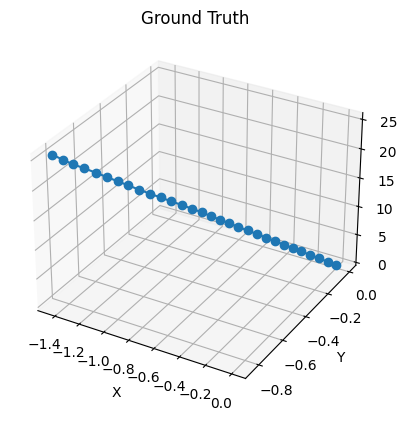

In [ ]:
# Extract the x, y, z coordinates from the trajectory
x = [pose[0, 3] for pose in truth]
y = [pose[1, 3] for pose in truth]
z = [pose[2, 3] for pose in truth]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
ax.plot(x, y, z, marker='o')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Ground Truth')

# Show the plot
plt.show()

## Mapeando a Point Cloud inicial

In [ ]:
#### Mapeando a point cloud inicial


def closest_point_indices(source_points, target_points):
    '''
    Inputs:
    source_points: point cloud origem
    target_points: point cloud alvo

    Output
    indices: indices dos pontos mapeados como vizinhos mais proximos'''

    tree = KDTree(target_points)                                                # A função KDTree provê agilidade ao algoritmo
    _, indices = tree.query(source_points)
    return indices

def best_fit_transform(source_points, target_points):
    '''
    Inputs:
    source_points: point cloud origem
    target_points: point cloud alvo

    Output:
    transformation: matriz de transformação (pose) estimada'''


    centroid_source = np.mean(source_points, axis=0)
    centroid_target = np.mean(target_points, axis=0)

    centered_source = source_points - centroid_source
    centered_target = target_points - centroid_target

    covariance_matrix = centered_source.T @ centered_target                     # Obtenção da matriz de covariância entre os pontos das point clouds de origem e de destino
    U, _, Vt = np.linalg.svd(covariance_matrix)                                 # Decomposição em valores singulares da matriz de covariância
    rotation_matrix = Vt.T @ U.T                                                # Obtenção da matriz de rotação a partir daquelas decompostas no SVD

    translation_vector = centroid_target - rotation_matrix @ centroid_source    # Obtenção do vetor de translação para alinhar centroides
    transformation = np.eye(4)                                                  # Inicialização da matriz de transformação (pose) estimada
    transformation[:3, :3] = rotation_matrix                                    # Atribui os valores de rotação à matriz
    transformation[:3, 3] = translation_vector                                  # Atribui os valores de translação à matriz
    return transformation

def icp(clouds, max_iterations=10, tolerance=0.001):
    '''
    Inputs:
    clouds: point clouds a serem trabalhadas (incluindo a target)
    max_iterations: maximo de iterações do algoritmo
    tolerance: tolerância a

    Output:
    trajectory: trajetoria estimada do carro
    '''
    trajectory = []                                                             # Inicialização da lista de poses
    pose = np.eye(4)                                                            # Pose inicial matriz identidade

    for i in range(0, len(clouds)):
        source_cloud = clouds[i]                                                # Loop de point clouds a serem mapeadas
        target_cloud = clouds[0]                                                # Point cloud alvo é a inicial

        prev_error = 0                                                          # Resetar o erro antes de iniciar um novo mapeamento

        for iteration in range(max_iterations):
            indices = closest_point_indices(source_cloud, target_cloud)         # Mapeamento dos indices de vizinhos mais proximos
            correspondences_source = source_cloud
            correspondences_target = target_cloud[indices]

            transformation = best_fit_transform(correspondences_source, correspondences_target) # Cálculo da melhor transformação
            pose = transformation @ pose                                        # Atualização da pose

            source_cloud_transformed = (pose[:3, :3] @ source_cloud.T + pose[:3, 3][:, np.newaxis]).T # Transforma a point cloud de origem




            error = np.mean(np.linalg.norm(source_cloud_transformed - correspondences_target, axis=1)) # Calcula o erro
            if abs(prev_error - error) < tolerance:                             # Critério de parada
                break
            prev_error = error

        trajectory.append(pose)                                                 # Inserção da pose na trajetoria

    return trajectory


In [ ]:
estimated_trajectory = icp(points)

[3.3306690738754696e-16, 0.10007016885831145, 0.14952287598260364, 0.406338605051125, 0.9472925115950518, 1.3819234137519147, 1.8222555136228706, 2.3005007718756003, 2.782985717249021, 3.1287819565175696, 3.4380482701828603, 3.7204471594007744, 3.821833863117516, 3.887503395202569, 3.564723147020095, 2.4482716242994025, 0.9733367127272213, 0.5616539599812079, 0.15081947562042275, -0.6570455162126941, -2.523712739582843, -4.929136820963982, -6.212993360514216, -6.760963450984598, -6.915095550403687, -7.233348964052921, -8.429144953654495, -10.084932427124237, -11.316361122108901, -11.627871699432086]
[8.881784197001252e-16, 0.23885360183846913, 0.8111753260414855, 1.4499884958880485, 1.965756032422136, 1.5615512215407088, 1.2357177229280807, 1.3592140069437584, 1.90138774362387, 2.614424988703726, 3.488825409304105, 4.587943000964466, 5.3892359131835486, 6.421299448269804, 7.643390862110855, 9.094631474628057, 10.591308871520486, 10.898488272387873, 10.060933739372047, 8.918075172880402

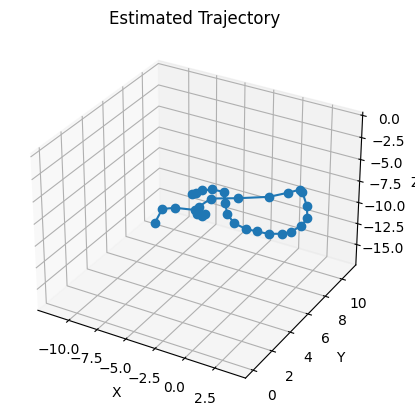

In [ ]:
# Extract the x, y, z coordinates from the trajectory
x = [pose[0, 3] for pose in estimated_trajectory]
y = [pose[1, 3] for pose in estimated_trajectory]
z = [pose[2, 3] for pose in estimated_trajectory]

print(x)
print(y)
print(z)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
ax.plot(x, y, z, marker='o')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Estimated Trajectory')

# Show the plot
plt.show()

[3.3306690738754696e-16, 0.10007016885831145, 0.14952287598260364, 0.406338605051125, 0.9472925115950518, 1.3819234137519147, 1.8222555136228706, 2.3005007718756003, 2.782985717249021, 3.1287819565175696, 3.4380482701828603, 3.7204471594007744, 3.821833863117516, 3.887503395202569, 3.564723147020095, 2.4482716242994025, 0.9733367127272213, 0.5616539599812079, 0.15081947562042275, -0.6570455162126941, -2.523712739582843, -4.929136820963982, -6.212993360514216, -6.760963450984598, -6.915095550403687, -7.233348964052921, -8.429144953654495, -10.084932427124237, -11.316361122108901, -11.627871699432086]
[8.881784197001252e-16, 0.23885360183846913, 0.8111753260414855, 1.4499884958880485, 1.965756032422136, 1.5615512215407088, 1.2357177229280807, 1.3592140069437584, 1.90138774362387, 2.614424988703726, 3.488825409304105, 4.587943000964466, 5.3892359131835486, 6.421299448269804, 7.643390862110855, 9.094631474628057, 10.591308871520486, 10.898488272387873, 10.060933739372047, 8.918075172880402

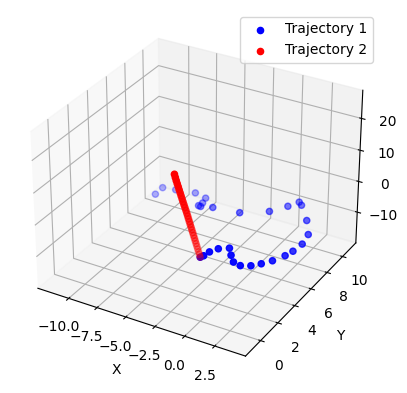

In [ ]:
# Primeira estimativa de trajetória
x1 = [pose[0, 3] for pose in estimated_trajectory]
y1 = [pose[1, 3] for pose in estimated_trajectory]
z1 = [pose[2, 3] for pose in estimated_trajectory]

print(x1)
print(y1)
print(z1)
print()

# Segunda estimativa de trajetória
x2 = [pose[0, 3] for pose in truth]
y2 = [pose[1, 3] for pose in truth]
z2 = [pose[2, 3] for pose in truth]

print(x2)
print(y2)
print(z2)

# Plotagem dos pontos da primeira trajetória
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, c='b', label='Trajectory 1')

# Plotagem dos pontos da segunda trajetória
ax.scatter(x2, y2, z2, c='r', label='Trajectory 2')

# Configurações adicionais do gráfico
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Mostrar o gráfico
plt.show()


## Abordagem com OPEN3D

Abordando a bilioteca Open3D pude ter o insight sobre os problemas que meu algoritmo estava enfrentando: trata-se da pose inicial. Esse é um dos problemas mais notáveis do algoritmo ICP, e foi o responsável pela inconsistência de meus resultados reportados neste notebook em relação à ground truth.


Isso foi verificado quando foi utilizada a biblioteca Open3D com inicialização padrão e não houve resultado satisfatório. Decidi então aplicar como pose inicial a ground-truth para ver a reação do algoritmo, e ele reconheceu a resposta correta.

In [ ]:
pip install open3d

In [ ]:
import open3d as o3d

In [ ]:
pontos_com_o3d = []
for i in range(len(points)):
    points_cloud = o3d.geometry.PointCloud()
    points_cloud.points = o3d.utility.Vector3dVector(points[i])
    pontos_com_o3d.append(points_cloud)

In [ ]:
pontos_com_o3d

[PointCloud with 62553 points.,
 PointCloud with 62340 points.,
 PointCloud with 62138 points.,
 PointCloud with 61833 points.,
 PointCloud with 61542 points.,
 PointCloud with 61375 points.,
 PointCloud with 61159 points.,
 PointCloud with 60197 points.,
 PointCloud with 59560 points.,
 PointCloud with 58954 points.,
 PointCloud with 59038 points.,
 PointCloud with 60849 points.,
 PointCloud with 61935 points.,
 PointCloud with 62687 points.,
 PointCloud with 63122 points.,
 PointCloud with 63202 points.,
 PointCloud with 62748 points.,
 PointCloud with 63098 points.,
 PointCloud with 62854 points.,
 PointCloud with 62570 points.,
 PointCloud with 62128 points.,
 PointCloud with 61925 points.,
 PointCloud with 61574 points.,
 PointCloud with 61391 points.,
 PointCloud with 61335 points.,
 PointCloud with 61300 points.,
 PointCloud with 61155 points.,
 PointCloud with 61145 points.,
 PointCloud with 62211 points.,
 PointCloud with 61793 points.]

In [ ]:
# Definir a primeira point cloud como a target
reference_cloud = pontos_com_o3d[0]

# Lista para armazenar as poses
transformations = [np.eye(4)]

for i in range(1, len(pontos_com_o3d)):
    current_cloud = pontos_com_o3d[i]

    # Aplicar o algoritmo ICP Point to Point com pose inicial ruim
    reg_p2p = o3d.pipelines.registration.registration_icp(
        current_cloud, reference_cloud, 0.001, truth[0],
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=100))

    # Obter a pose resultante
    transformation = reg_p2p.transformation

    # Adição à lista de poses
    transformations.append(transformation)

    # Mapear a nuvem atual para a nuvem target
    current_cloud.transform(transformation)

[0.0, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17, 5.551115e-17]
[0.0, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16, 3.330669e-16]
[0.0, -4.440892e-16, -4.440892e-16, -4.440892e-16, -4.440892e-16, -4.440892e-16, -4.440892e-16, -4.440892e-16, -4.440892e-16, -4.440892e-16, -4.440892e-16, -4.440892e-16, -4.44

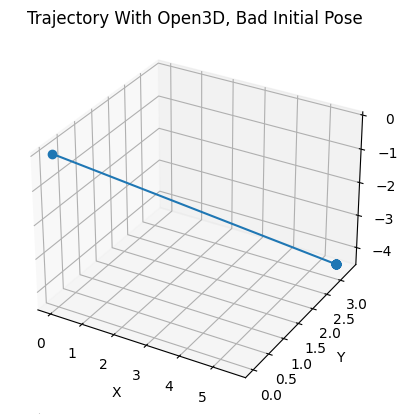

In [ ]:
x = [pose[0, 3] for pose in transformations]
y = [pose[1, 3] for pose in transformations]
z = [pose[2, 3] for pose in transformations]

print(x)
print(y)
print(z)

# Espaço 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotar a trajetoria
ax.plot(x, y, z, marker='o')

# Labels e titulo
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Trajectory With Open3D, Bad Initial Pose')


plt.show()

In [ ]:
# Definir a primeira point cloud como a nuvem target
reference_cloud = pontos_com_o3d[0]

# Lista para armazenar as pose
transformations = [np.eye(4)]  # A primeira pose é a identidade

for i in range(1, len(pontos_com_o3d)):
    current_cloud = pontos_com_o3d[i]

    # Aplicar o algoritmo ICP com a pose inicial ideal
    reg_p2p = o3d.pipelines.registration.registration_icp(
        current_cloud, reference_cloud, 0.001, truth[i],
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=100))

    # Obter a pose resultante
    transformation = reg_p2p.transformation

    # Adição da pose à lista
    transformations.append(transformation)

    # Mapear a nuvem atual para a nuvem target
    current_cloud.transform(transformation)

[0.0, -0.04690294, -0.09374345, -0.1406429, -0.1874858, -0.2343818, -0.2812195, -0.3281178, -0.3749547, -0.4218367, -0.4687329, -0.5155474, -0.562431, -0.6093087, -0.6562052, -0.7018788, -0.7498241, -0.7992511, -0.8546642, -0.9072868, -0.9609163, -1.011589, -1.066256, -1.118651, -1.17184, -1.224279, -1.280807, -1.334841, -1.385747, -1.436633]
[0.0, -0.02839928, -0.05676064, -0.08515762, -0.1135202, -0.141915, -0.1702743, -0.1986703, -0.227029, -0.2554151, -0.2838096, -0.3121547, -0.3405416, -0.368925, -0.3973964, -0.4239119, -0.4540039, -0.484077, -0.515507, -0.5464705, -0.5783595, -0.6092403, -0.6387363, -0.6686219, -0.6990778, -0.7287421, -0.7604717, -0.7929673, -0.8209244, -0.8456208]
[0.0, 0.8586941, 1.716275, 2.574964, 3.432648, 4.291335, 5.148987, 6.007777, 6.865477, 7.724036, 8.582886, 9.440275, 10.29896, 11.15757, 12.01541, 12.86965, 13.73146, 14.60026, 15.47957, 16.3694, 17.26896, 18.17318, 19.08411, 19.99722, 20.91368, 21.84042, 22.77432, 23.70953, 24.65175, 25.59694]


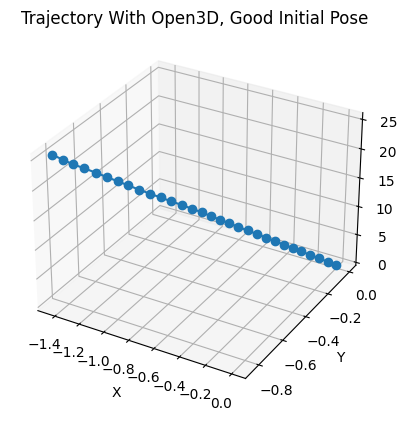

In [ ]:
x = [pose[0, 3] for pose in transformations]
y = [pose[1, 3] for pose in transformations]
z = [pose[2, 3] for pose in transformations]

print(x)
print(y)
print(z)

# Espaço 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotar a trajetória
ax.plot(x, y, z, marker='o')

# Labels e titulo
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Trajectory With Open3D, Good Initial Pose')

plt.show()

[0.10007016885831112, 0.017568064282053597, 0.02297702556131587, -0.007474322092706864, 0.07470423178975301, 0.0360502005961117, -0.059175174968593536, -0.12488613443863629, -0.2422035931655605, -0.23112822723967216, -0.3381007042991481, -0.4390653677943351, -0.4846774025910429, -0.5386249969346969, -0.6083883674357904, -0.6861582750355797, -0.8191506463328204, -0.8188788270391313, -1.1973606405338475, -1.4852626314481954, -1.8144546896773353, -1.8489756015567467, -1.874073118557845, -1.850786558207218, -1.6609578361241917, -1.4697514349104153, -1.2318767938457522, -0.856099408275917, -0.36798739834947963]
[0.23885360183846824, 0.6044248581719195, 1.00913719630153, 1.560737379788785, 2.174656409951039, 2.712736033337585, 3.441680978754379, 4.351484867440668, 5.346330753733548, 6.226089306925476, 6.8573527593339865, 7.580141365809284, 8.136154878196276, 9.054661278136305, 9.8636389525298, 10.452304028566433, 11.158878284759362, 11.840662871109389, 12.876980872393693, 13.909720919973683,

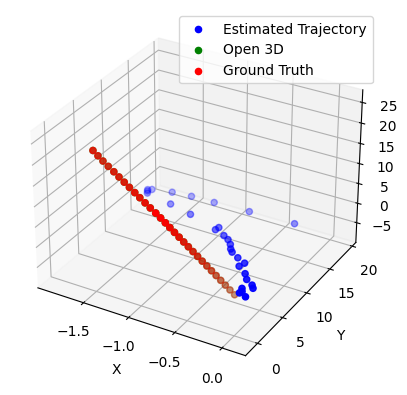

In [ ]:
# Primeira estimativa de trajetória
x1 = [pose[0, 3] for pose in estimated_trajectory]
y1 = [pose[1, 3] for pose in estimated_trajectory]
z1 = [pose[2, 3] for pose in estimated_trajectory]

print(x1)
print(y1)
print(z1)
print()



# Open3D
x2 = [pose[0, 3] for pose in transformations]
y2 = [pose[1, 3] for pose in transformations]
z2 = [pose[2, 3] for pose in transformations]

print(x2)
print(y2)
print(z2)
print()

# Ground-Truth
x3 = [pose[0, 3] for pose in truth]
y3 = [pose[1, 3] for pose in truth]
z3 = [pose[2, 3] for pose in truth]

print(x3)
print(y3)
print(z3)


# Plotagem dos pontos da primeira trajetória
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, c='b', label='Estimated Trajectory')

# Plotagem dos pontos da segunda trajetória
ax.scatter(x2, y2, z2, c='g', label='Open 3D')

# Plotagem dos pontos da segunda trajetória
ax.scatter(x3, y3, z3, c='r', label='Ground Truth')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Mostrar o gráfico
plt.show()

# Conclusões

Os resultados do trabalho exposto neste relatório indicam que o algoritmo ICP tem forte dependência de que a pose inicial das point clouds seja suficientemente adequada para a convergência dos resultados.

Outra possibilidade de obtenção de resultados satisfatórios depende de que seja explicitada uma correspondência entre pontos das diferentes point clouds.